In [1]:
import numpy as np
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Input, Dense, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Embedding, Concatenate, Reshape, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
data_folder_path = "/content/drive/MyDrive/Gans revisited/cartoon_dataset"

In [3]:
folders = os.listdir(data_folder_path)

In [ ]:
all_images = []
for folder in folders:
  print(folder)
  folder_images_path_list = os.listdir(data_folder_path+ f"/{folder}")
  print(len(folder_images_path_list))
  # if folder == "9":
  for image_path in folder_images_path_list:
    img = Image.open(data_folder_path + f"/{folder}/{image_path}")
    img = img.resize((64,64),Image.ANTIALIAS)

    all_images.append(np.array(img))

9
3303


In [ ]:
np.array(all_images).shape

(3303, 64, 64, 3)

In [ ]:
# import pickle
# with open('file.pkl', 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(myvar, file)


In [ ]:
cartoons = np.array(all_images)

In [ ]:
cartoons[0].shape

(64, 64, 3)

In [ ]:
img_rows = 64
img_cols = 64
channels = 3
img_shape = (img_rows, img_cols, channels)

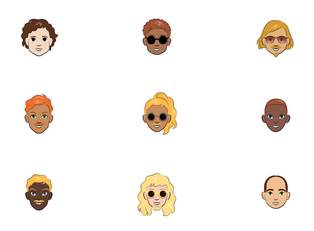

In [ ]:
# plt.figsize = (20,20)
for i in range(9):
  plt.subplot(3,3,i + 1)
  plt.axis("off")
  plt.imshow(cartoons[i])
plt.show()

In [ ]:
def build_generator():
    noise_shape = (100,)
    model = Sequential()
    

    model.add(Dense(256, input_shape = noise_shape, activation = "relu"))
    model.add(Reshape((16,16,1)))
    model.add(Conv2DTranspose(256, (4,4), strides = (2,2), padding = "same"))
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Conv2DTranspose(256, (4,4), strides = (2,2), padding = "same"))
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Conv2D(128, (3,3), padding = "same"))
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Conv2D(64, (4,4), padding = "same"))
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Conv2D(32, (3,3), padding = "same"))
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Conv2D(32, (3,3), padding = "same"))
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Conv2D(16, (3,3), padding = "same"))
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Conv2D(3, (3,3), padding = "same"))
    model.add(LeakyReLU(alpha = 0.2))



    # model = Model(inp, gen)

    print(model.summary())

    noise = Input(shape = noise_shape)
    img = model(noise)

    return Model(noise, img)

In [ ]:
build_generator()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 256)               25856     
                                                                 
 reshape_19 (Reshape)        (None, 16, 16, 1)         0         
                                                                 
 conv2d_transpose_47 (Conv2D  (None, 32, 32, 256)      4352      
 Transpose)                                                      
                                                                 
 leaky_re_lu_187 (LeakyReLU)  (None, 32, 32, 256)      0         
                                                                 
 conv2d_transpose_48 (Conv2D  (None, 64, 64, 256)      1048832   
 Transpose)                                                      
                                                                 
 leaky_re_lu_188 (LeakyReLU)  (None, 64, 64, 256)    

In [ ]:
def build_discriminator():

  model = Sequential()

  model.add(Conv2D(8, (5,5), input_shape = img_shape, strides = (2,2)))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2D(16, (5,5), strides = (2,2)))
  model.add(LeakyReLU(alpha = 0.2))

  # model.add(Conv2D(32, (5,5), strides = (2,2)))
  # model.add(LeakyReLU(alpha = 0.2))

  # model.add(Conv2D(64, (5,5), strides = (2,2)))
  # model.add(LeakyReLU(alpha = 0.2))


  model.add(Flatten())

  model.add(Dense(128))
  model.add(LeakyReLU(alpha = 0.2))

  # model.add(Dense(256))
  # model.add(LeakyReLU(alpha = 0.2))

  model.add(Dense(1, activation = "sigmoid"))
  model.summary()

  img = Input(shape = img_shape)
  validity = model(img)

  return Model(img, validity)

In [ ]:
build_discriminator()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_116 (Conv2D)         (None, 30, 30, 8)         608       
                                                                 
 leaky_re_lu_195 (LeakyReLU)  (None, 30, 30, 8)        0         
                                                                 
 conv2d_117 (Conv2D)         (None, 13, 13, 16)        3216      
                                                                 
 leaky_re_lu_196 (LeakyReLU)  (None, 13, 13, 16)       0         
                                                                 
 flatten_17 (Flatten)        (None, 2704)              0         
                                                                 
 dense_67 (Dense)            (None, 128)               346240    
                                                                 
 leaky_re_lu_197 (LeakyReLU)  (None, 128)            

In [ ]:
def train(cartoons, generator, discriminator, combined,  epochs, batch_size = 16, save_interval = 50):

  # scaling the cartoons dataset
  cartoons = (cartoons.astype(np.float32) - 127.5)/127.5

  # no need to expand the 4th dimanesion as it is a coloured image and already expanded
  # if your image is not colored and you want to make a generic model then you need to expand it.

  half_batch = batch_size // 2

  # Now making our very own training function as the fit method won't work with the type of setting we are dealing with

  for epoch in range(epochs):

    idx = np.random.randint(0, cartoons.shape[0], half_batch)
    cartoon_imgs = cartoons[idx]

    noises = np.random.normal(0, 1, (half_batch, 100))

    gen_imgs = generator.predict(noises)

    d_loss_real = discriminator.train_on_batch(cartoon_imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

    d_loss_avg = (np.add(d_loss_real, d_loss_fake)) * 0.5

    noise = np.random.normal(0, 1, (half_batch, 100))

    valid_y = np.array([1] * half_batch)

    print(f"Noise Shape: {noise.shape}")
    print(f"valid Shape: {valid_y.shape}")

    g_loss = combined.train_on_batch(noise, valid_y)

    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss_avg[0], 100*d_loss_avg[1], g_loss))

    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
        save_imgs(epoch)


In [ ]:
def save_imgs(epoch):
  r, c = 5, 5

  noise = np.random.normal(0, 1, (r*c, 100))
  gen_imgs = generator.predict(noise)

  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axis = plt.subplots(r,c)
  cnt = 0

  for i in range(r):
    for j in range(c):
      axis[i, j].imshow(gen_imgs[cnt, :, :, :])
      axis[i,j].axis("off")
      cnt += 1
  fig.savefig(f"/content/cartoons/cartoons_{epoch}.png")
  plt.close()


In [ ]:
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.


In [ ]:
discriminator = build_discriminator()
discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_118 (Conv2D)         (None, 30, 30, 8)         608       
                                                                 
 leaky_re_lu_198 (LeakyReLU)  (None, 30, 30, 8)        0         
                                                                 
 conv2d_119 (Conv2D)         (None, 13, 13, 16)        3216      
                                                                 
 leaky_re_lu_199 (LeakyReLU)  (None, 13, 13, 16)       0         
                                                                 
 flatten_18 (Flatten)        (None, 2704)              0         
                                                                 
 dense_69 (Dense)            (None, 128)               346240    
                                                                 
 leaky_re_lu_200 (LeakyReLU)  (None, 128)            

In [ ]:
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 256)               25856     
                                                                 
 reshape_20 (Reshape)        (None, 16, 16, 1)         0         
                                                                 
 conv2d_transpose_49 (Conv2D  (None, 32, 32, 256)      4352      
 Transpose)                                                      
                                                                 
 leaky_re_lu_201 (LeakyReLU)  (None, 32, 32, 256)      0         
                                                                 
 conv2d_transpose_50 (Conv2D  (None, 64, 64, 256)      1048832   
 Transpose)                                                      
                                                                 
 leaky_re_lu_202 (LeakyReLU)  (None, 64, 64, 256)    

In [ ]:
z = Input(shape = (100,))

In [ ]:
img = generator(z)


In [ ]:
discriminator.trainable = False  


In [ ]:
valid = discriminator(img)

In [ ]:
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


In [ ]:
train(cartoons, generator, discriminator, combined, epochs=30000, batch_size=8, save_interval=1000)


Noise Shape: (4, 100)
valid Shape: (4,)
0 [D loss: 0.617727, acc.: 50.00%] [G loss: 0.692640]
Noise Shape: (4, 100)
valid Shape: (4,)
1 [D loss: 0.442106, acc.: 50.00%] [G loss: 0.690036]
Noise Shape: (4, 100)
valid Shape: (4,)
2 [D loss: 0.395950, acc.: 50.00%] [G loss: 0.679173]
Noise Shape: (4, 100)
valid Shape: (4,)
3 [D loss: 0.384830, acc.: 50.00%] [G loss: 0.655123]
Noise Shape: (4, 100)
valid Shape: (4,)
4 [D loss: 0.406596, acc.: 50.00%] [G loss: 0.613735]
Noise Shape: (4, 100)
valid Shape: (4,)
5 [D loss: 0.450900, acc.: 50.00%] [G loss: 0.595777]
Noise Shape: (4, 100)
valid Shape: (4,)
6 [D loss: 0.472406, acc.: 50.00%] [G loss: 0.692669]
Noise Shape: (4, 100)
valid Shape: (4,)
7 [D loss: 0.423372, acc.: 62.50%] [G loss: 1.000282]
Noise Shape: (4, 100)
valid Shape: (4,)
8 [D loss: 0.419490, acc.: 100.00%] [G loss: 0.840097]
Noise Shape: (4, 100)
valid Shape: (4,)
9 [D loss: 0.430685, acc.: 62.50%] [G loss: 0.727491]
Noise Shape: (4, 100)
valid Shape: (4,)
10 [D loss: 0.37111

Noise Shape: (4, 100)
valid Shape: (4,)
1001 [D loss: 0.022066, acc.: 100.00%] [G loss: 4.539949]
Noise Shape: (4, 100)
valid Shape: (4,)
1002 [D loss: 0.007578, acc.: 100.00%] [G loss: 5.869425]
Noise Shape: (4, 100)
valid Shape: (4,)
1003 [D loss: 0.009978, acc.: 100.00%] [G loss: 6.990916]
Noise Shape: (4, 100)
valid Shape: (4,)
1004 [D loss: 0.007007, acc.: 100.00%] [G loss: 6.326816]
Noise Shape: (4, 100)
valid Shape: (4,)
1005 [D loss: 0.358489, acc.: 87.50%] [G loss: 3.698146]
Noise Shape: (4, 100)
valid Shape: (4,)
1006 [D loss: 0.013320, acc.: 100.00%] [G loss: 5.648811]
Noise Shape: (4, 100)
valid Shape: (4,)
1007 [D loss: 0.023465, acc.: 100.00%] [G loss: 5.964011]
Noise Shape: (4, 100)
valid Shape: (4,)
1008 [D loss: 0.011028, acc.: 100.00%] [G loss: 4.818238]
Noise Shape: (4, 100)
valid Shape: (4,)
1009 [D loss: 0.033991, acc.: 100.00%] [G loss: 3.968158]
Noise Shape: (4, 100)
valid Shape: (4,)
1010 [D loss: 0.035699, acc.: 100.00%] [G loss: 7.157208]
Noise Shape: (4, 100)

Noise Shape: (4, 100)
valid Shape: (4,)
2001 [D loss: 0.180133, acc.: 87.50%] [G loss: 2.694046]
Noise Shape: (4, 100)
valid Shape: (4,)
2002 [D loss: 0.060006, acc.: 100.00%] [G loss: 5.282654]
Noise Shape: (4, 100)
valid Shape: (4,)
2003 [D loss: 0.098278, acc.: 100.00%] [G loss: 5.448110]
Noise Shape: (4, 100)
valid Shape: (4,)
2004 [D loss: 0.082222, acc.: 100.00%] [G loss: 4.170521]
Noise Shape: (4, 100)
valid Shape: (4,)
2005 [D loss: 0.354404, acc.: 87.50%] [G loss: 3.783024]
Noise Shape: (4, 100)
valid Shape: (4,)
2006 [D loss: 0.136538, acc.: 100.00%] [G loss: 4.346231]
Noise Shape: (4, 100)
valid Shape: (4,)
2007 [D loss: 0.149916, acc.: 87.50%] [G loss: 4.262145]
Noise Shape: (4, 100)
valid Shape: (4,)
2008 [D loss: 0.167377, acc.: 100.00%] [G loss: 2.005915]
Noise Shape: (4, 100)
valid Shape: (4,)
2009 [D loss: 0.038043, acc.: 100.00%] [G loss: 2.793454]
Noise Shape: (4, 100)
valid Shape: (4,)
2010 [D loss: 0.078135, acc.: 100.00%] [G loss: 3.222197]
Noise Shape: (4, 100)
v

Noise Shape: (4, 100)
valid Shape: (4,)
3001 [D loss: 0.326486, acc.: 87.50%] [G loss: 4.298557]
Noise Shape: (4, 100)
valid Shape: (4,)
3002 [D loss: 0.173615, acc.: 100.00%] [G loss: 1.408781]
Noise Shape: (4, 100)
valid Shape: (4,)
3003 [D loss: 0.266155, acc.: 87.50%] [G loss: 3.516054]
Noise Shape: (4, 100)
valid Shape: (4,)
3004 [D loss: 0.024854, acc.: 100.00%] [G loss: 3.784921]
Noise Shape: (4, 100)
valid Shape: (4,)
3005 [D loss: 0.180458, acc.: 100.00%] [G loss: 1.913429]
Noise Shape: (4, 100)
valid Shape: (4,)
3006 [D loss: 0.136328, acc.: 87.50%] [G loss: 1.445928]
Noise Shape: (4, 100)
valid Shape: (4,)
3007 [D loss: 0.223856, acc.: 87.50%] [G loss: 3.046364]
Noise Shape: (4, 100)
valid Shape: (4,)
3008 [D loss: 0.381407, acc.: 87.50%] [G loss: 1.339052]
Noise Shape: (4, 100)
valid Shape: (4,)
3009 [D loss: 0.295186, acc.: 87.50%] [G loss: 2.840922]
Noise Shape: (4, 100)
valid Shape: (4,)
3010 [D loss: 0.056501, acc.: 100.00%] [G loss: 4.103466]
Noise Shape: (4, 100)
vali

Noise Shape: (4, 100)
valid Shape: (4,)
4001 [D loss: 0.115124, acc.: 100.00%] [G loss: 3.681682]
Noise Shape: (4, 100)
valid Shape: (4,)
4002 [D loss: 0.210453, acc.: 87.50%] [G loss: 2.834873]
Noise Shape: (4, 100)
valid Shape: (4,)
4003 [D loss: 0.288924, acc.: 87.50%] [G loss: 3.613665]
Noise Shape: (4, 100)
valid Shape: (4,)
4004 [D loss: 0.197796, acc.: 100.00%] [G loss: 2.355063]
Noise Shape: (4, 100)
valid Shape: (4,)
4005 [D loss: 0.179993, acc.: 87.50%] [G loss: 2.740007]
Noise Shape: (4, 100)
valid Shape: (4,)
4006 [D loss: 0.084865, acc.: 100.00%] [G loss: 2.151495]
Noise Shape: (4, 100)
valid Shape: (4,)
4007 [D loss: 0.136312, acc.: 100.00%] [G loss: 2.574828]
Noise Shape: (4, 100)
valid Shape: (4,)
4008 [D loss: 0.083254, acc.: 100.00%] [G loss: 4.581950]
Noise Shape: (4, 100)
valid Shape: (4,)
4009 [D loss: 0.076547, acc.: 100.00%] [G loss: 3.379761]
Noise Shape: (4, 100)
valid Shape: (4,)
4010 [D loss: 0.102328, acc.: 100.00%] [G loss: 2.819545]
Noise Shape: (4, 100)
v

Noise Shape: (4, 100)
valid Shape: (4,)
5001 [D loss: 0.387931, acc.: 75.00%] [G loss: 2.764079]
Noise Shape: (4, 100)
valid Shape: (4,)
5002 [D loss: 0.076907, acc.: 100.00%] [G loss: 4.680093]
Noise Shape: (4, 100)
valid Shape: (4,)
5003 [D loss: 0.585568, acc.: 87.50%] [G loss: 3.535776]
Noise Shape: (4, 100)
valid Shape: (4,)
5004 [D loss: 0.034094, acc.: 100.00%] [G loss: 2.854230]
Noise Shape: (4, 100)
valid Shape: (4,)
5005 [D loss: 0.097801, acc.: 100.00%] [G loss: 3.013577]
Noise Shape: (4, 100)
valid Shape: (4,)
5006 [D loss: 0.045025, acc.: 100.00%] [G loss: 2.526011]
Noise Shape: (4, 100)
valid Shape: (4,)
5007 [D loss: 0.047774, acc.: 100.00%] [G loss: 3.344540]
Noise Shape: (4, 100)
valid Shape: (4,)
5008 [D loss: 0.386341, acc.: 87.50%] [G loss: 3.953793]
Noise Shape: (4, 100)
valid Shape: (4,)
5009 [D loss: 0.104508, acc.: 100.00%] [G loss: 3.274574]
Noise Shape: (4, 100)
valid Shape: (4,)
5010 [D loss: 0.054174, acc.: 100.00%] [G loss: 2.032793]
Noise Shape: (4, 100)
v

Noise Shape: (4, 100)
valid Shape: (4,)
6001 [D loss: 0.038281, acc.: 100.00%] [G loss: 3.710856]
Noise Shape: (4, 100)
valid Shape: (4,)
6002 [D loss: 0.641254, acc.: 75.00%] [G loss: 3.098907]
Noise Shape: (4, 100)
valid Shape: (4,)
6003 [D loss: 0.012392, acc.: 100.00%] [G loss: 3.211269]
Noise Shape: (4, 100)
valid Shape: (4,)
6004 [D loss: 0.385762, acc.: 87.50%] [G loss: 2.381471]
Noise Shape: (4, 100)
valid Shape: (4,)
6005 [D loss: 0.063053, acc.: 100.00%] [G loss: 3.892018]
Noise Shape: (4, 100)
valid Shape: (4,)
6006 [D loss: 0.032736, acc.: 100.00%] [G loss: 3.110271]
Noise Shape: (4, 100)
valid Shape: (4,)
6007 [D loss: 0.075701, acc.: 100.00%] [G loss: 3.857651]
Noise Shape: (4, 100)
valid Shape: (4,)
6008 [D loss: 0.008886, acc.: 100.00%] [G loss: 3.087798]
Noise Shape: (4, 100)
valid Shape: (4,)
6009 [D loss: 0.031897, acc.: 100.00%] [G loss: 4.706849]
Noise Shape: (4, 100)
valid Shape: (4,)
6010 [D loss: 0.448923, acc.: 87.50%] [G loss: 3.320893]
Noise Shape: (4, 100)
v

Noise Shape: (4, 100)
valid Shape: (4,)
7001 [D loss: 0.059357, acc.: 100.00%] [G loss: 4.005185]
Noise Shape: (4, 100)
valid Shape: (4,)
7002 [D loss: 0.010546, acc.: 100.00%] [G loss: 3.366110]
Noise Shape: (4, 100)
valid Shape: (4,)
7003 [D loss: 0.019821, acc.: 100.00%] [G loss: 3.942051]
Noise Shape: (4, 100)
valid Shape: (4,)
7004 [D loss: 0.466672, acc.: 87.50%] [G loss: 2.046032]
Noise Shape: (4, 100)
valid Shape: (4,)
7005 [D loss: 0.188931, acc.: 87.50%] [G loss: 3.530705]
Noise Shape: (4, 100)
valid Shape: (4,)
7006 [D loss: 0.098850, acc.: 100.00%] [G loss: 3.106589]
Noise Shape: (4, 100)
valid Shape: (4,)
7007 [D loss: 0.076848, acc.: 100.00%] [G loss: 3.700158]
Noise Shape: (4, 100)
valid Shape: (4,)
7008 [D loss: 0.234843, acc.: 87.50%] [G loss: 3.530513]
Noise Shape: (4, 100)
valid Shape: (4,)
7009 [D loss: 0.046315, acc.: 100.00%] [G loss: 3.104797]
Noise Shape: (4, 100)
valid Shape: (4,)
7010 [D loss: 0.785413, acc.: 87.50%] [G loss: 2.887601]
Noise Shape: (4, 100)
va

Noise Shape: (4, 100)
valid Shape: (4,)
8001 [D loss: 0.047540, acc.: 100.00%] [G loss: 2.972145]
Noise Shape: (4, 100)
valid Shape: (4,)
8002 [D loss: 0.033308, acc.: 100.00%] [G loss: 3.172729]
Noise Shape: (4, 100)
valid Shape: (4,)
8003 [D loss: 0.019034, acc.: 100.00%] [G loss: 3.365807]
Noise Shape: (4, 100)
valid Shape: (4,)
8004 [D loss: 0.022294, acc.: 100.00%] [G loss: 3.580075]
Noise Shape: (4, 100)
valid Shape: (4,)
8005 [D loss: 0.215467, acc.: 87.50%] [G loss: 2.728805]
Noise Shape: (4, 100)
valid Shape: (4,)
8006 [D loss: 0.034448, acc.: 100.00%] [G loss: 3.533353]
Noise Shape: (4, 100)
valid Shape: (4,)
8007 [D loss: 0.032892, acc.: 100.00%] [G loss: 3.063468]
Noise Shape: (4, 100)
valid Shape: (4,)
8008 [D loss: 0.029313, acc.: 100.00%] [G loss: 3.504556]
Noise Shape: (4, 100)
valid Shape: (4,)
8009 [D loss: 0.036200, acc.: 100.00%] [G loss: 3.564971]
Noise Shape: (4, 100)
valid Shape: (4,)
8010 [D loss: 0.022908, acc.: 100.00%] [G loss: 3.539323]
Noise Shape: (4, 100)

Noise Shape: (4, 100)
valid Shape: (4,)
9001 [D loss: 0.055248, acc.: 100.00%] [G loss: 2.911809]
Noise Shape: (4, 100)
valid Shape: (4,)
9002 [D loss: 0.775425, acc.: 75.00%] [G loss: 2.145485]
Noise Shape: (4, 100)
valid Shape: (4,)
9003 [D loss: 0.366622, acc.: 87.50%] [G loss: 1.603529]
Noise Shape: (4, 100)
valid Shape: (4,)
9004 [D loss: 0.132220, acc.: 100.00%] [G loss: 2.667370]
Noise Shape: (4, 100)
valid Shape: (4,)
9005 [D loss: 0.218643, acc.: 87.50%] [G loss: 2.976019]
Noise Shape: (4, 100)
valid Shape: (4,)
9006 [D loss: 0.040168, acc.: 100.00%] [G loss: 3.154736]
Noise Shape: (4, 100)
valid Shape: (4,)
9007 [D loss: 0.054343, acc.: 100.00%] [G loss: 3.133279]
Noise Shape: (4, 100)
valid Shape: (4,)
9008 [D loss: 0.181616, acc.: 87.50%] [G loss: 2.653607]
Noise Shape: (4, 100)
valid Shape: (4,)
9009 [D loss: 0.058649, acc.: 100.00%] [G loss: 2.831867]
Noise Shape: (4, 100)
valid Shape: (4,)
9010 [D loss: 0.311343, acc.: 87.50%] [G loss: 2.648689]
Noise Shape: (4, 100)
val

Noise Shape: (4, 100)
valid Shape: (4,)
10001 [D loss: 0.026189, acc.: 100.00%] [G loss: 3.269772]
Noise Shape: (4, 100)
valid Shape: (4,)
10002 [D loss: 0.209436, acc.: 87.50%] [G loss: 2.331634]
Noise Shape: (4, 100)
valid Shape: (4,)
10003 [D loss: 0.036755, acc.: 100.00%] [G loss: 2.877948]
Noise Shape: (4, 100)
valid Shape: (4,)
10004 [D loss: 0.062721, acc.: 100.00%] [G loss: 2.754411]
Noise Shape: (4, 100)
valid Shape: (4,)
10005 [D loss: 0.494951, acc.: 87.50%] [G loss: 2.311500]
Noise Shape: (4, 100)
valid Shape: (4,)
10006 [D loss: 0.067320, acc.: 100.00%] [G loss: 2.588186]
Noise Shape: (4, 100)
valid Shape: (4,)
10007 [D loss: 0.035251, acc.: 100.00%] [G loss: 3.141618]
Noise Shape: (4, 100)
valid Shape: (4,)
10008 [D loss: 0.391231, acc.: 87.50%] [G loss: 2.404503]
Noise Shape: (4, 100)
valid Shape: (4,)
10009 [D loss: 0.158655, acc.: 100.00%] [G loss: 2.629760]
Noise Shape: (4, 100)
valid Shape: (4,)
10010 [D loss: 0.019285, acc.: 100.00%] [G loss: 3.396932]
Noise Shape: 

Noise Shape: (4, 100)
valid Shape: (4,)
11001 [D loss: 0.052393, acc.: 100.00%] [G loss: 3.450666]
Noise Shape: (4, 100)
valid Shape: (4,)
11002 [D loss: 0.766647, acc.: 62.50%] [G loss: 3.826469]
Noise Shape: (4, 100)
valid Shape: (4,)
11003 [D loss: 0.238079, acc.: 87.50%] [G loss: 3.995819]
Noise Shape: (4, 100)
valid Shape: (4,)
11004 [D loss: 0.144597, acc.: 87.50%] [G loss: 2.411661]
Noise Shape: (4, 100)
valid Shape: (4,)
11005 [D loss: 0.331831, acc.: 87.50%] [G loss: 3.540207]
Noise Shape: (4, 100)
valid Shape: (4,)
11006 [D loss: 1.589595, acc.: 87.50%] [G loss: 2.148709]
Noise Shape: (4, 100)
valid Shape: (4,)
11007 [D loss: 0.136840, acc.: 100.00%] [G loss: 2.340735]
Noise Shape: (4, 100)
valid Shape: (4,)
11008 [D loss: 0.350697, acc.: 87.50%] [G loss: 5.551623]
Noise Shape: (4, 100)
valid Shape: (4,)
11009 [D loss: 0.069097, acc.: 100.00%] [G loss: 4.608274]
Noise Shape: (4, 100)
valid Shape: (4,)
11010 [D loss: 0.008760, acc.: 100.00%] [G loss: 5.795484]
Noise Shape: (4,

Noise Shape: (4, 100)
valid Shape: (4,)
12001 [D loss: 0.101845, acc.: 100.00%] [G loss: 3.562487]
Noise Shape: (4, 100)
valid Shape: (4,)
12002 [D loss: 0.343837, acc.: 75.00%] [G loss: 2.380658]
Noise Shape: (4, 100)
valid Shape: (4,)
12003 [D loss: 0.089740, acc.: 100.00%] [G loss: 2.870891]
Noise Shape: (4, 100)
valid Shape: (4,)
12004 [D loss: 0.034423, acc.: 100.00%] [G loss: 3.218878]
Noise Shape: (4, 100)
valid Shape: (4,)
12005 [D loss: 0.028662, acc.: 100.00%] [G loss: 3.479023]
Noise Shape: (4, 100)
valid Shape: (4,)
12006 [D loss: 0.018089, acc.: 100.00%] [G loss: 3.537951]
Noise Shape: (4, 100)
valid Shape: (4,)
12007 [D loss: 0.026875, acc.: 100.00%] [G loss: 3.451209]
Noise Shape: (4, 100)
valid Shape: (4,)
12008 [D loss: 0.040510, acc.: 100.00%] [G loss: 3.197393]
Noise Shape: (4, 100)
valid Shape: (4,)
12009 [D loss: 0.722216, acc.: 75.00%] [G loss: 2.121193]
Noise Shape: (4, 100)
valid Shape: (4,)
12010 [D loss: 0.776018, acc.: 87.50%] [G loss: 2.709583]
Noise Shape: 

Noise Shape: (4, 100)
valid Shape: (4,)
13001 [D loss: 0.150436, acc.: 87.50%] [G loss: 2.933211]
Noise Shape: (4, 100)
valid Shape: (4,)
13002 [D loss: 0.056884, acc.: 100.00%] [G loss: 2.976074]
Noise Shape: (4, 100)
valid Shape: (4,)
13003 [D loss: 0.122664, acc.: 100.00%] [G loss: 2.764009]
Noise Shape: (4, 100)
valid Shape: (4,)
13004 [D loss: 0.064102, acc.: 100.00%] [G loss: 2.823323]
Noise Shape: (4, 100)
valid Shape: (4,)
13005 [D loss: 0.220228, acc.: 87.50%] [G loss: 2.503439]
Noise Shape: (4, 100)
valid Shape: (4,)
13006 [D loss: 0.060589, acc.: 100.00%] [G loss: 2.765713]
Noise Shape: (4, 100)
valid Shape: (4,)
13007 [D loss: 0.076626, acc.: 100.00%] [G loss: 2.897561]
Noise Shape: (4, 100)
valid Shape: (4,)
13008 [D loss: 0.026934, acc.: 100.00%] [G loss: 3.364358]
Noise Shape: (4, 100)
valid Shape: (4,)
13009 [D loss: 0.104090, acc.: 100.00%] [G loss: 2.675677]
Noise Shape: (4, 100)
valid Shape: (4,)
13010 [D loss: 0.066354, acc.: 100.00%] [G loss: 2.850353]
Noise Shape:

Noise Shape: (4, 100)
valid Shape: (4,)
14001 [D loss: 0.824632, acc.: 75.00%] [G loss: 1.655098]
Noise Shape: (4, 100)
valid Shape: (4,)
14002 [D loss: 0.263411, acc.: 100.00%] [G loss: 3.018515]
Noise Shape: (4, 100)
valid Shape: (4,)
14003 [D loss: 0.019850, acc.: 100.00%] [G loss: 4.686244]
Noise Shape: (4, 100)
valid Shape: (4,)
14004 [D loss: 0.096805, acc.: 100.00%] [G loss: 3.312130]
Noise Shape: (4, 100)
valid Shape: (4,)
14005 [D loss: 0.073887, acc.: 100.00%] [G loss: 2.858510]
Noise Shape: (4, 100)
valid Shape: (4,)
14006 [D loss: 0.196289, acc.: 100.00%] [G loss: 2.787055]
Noise Shape: (4, 100)
valid Shape: (4,)
14007 [D loss: 0.099115, acc.: 100.00%] [G loss: 3.250787]
Noise Shape: (4, 100)
valid Shape: (4,)
14008 [D loss: 0.289258, acc.: 87.50%] [G loss: 2.808962]
Noise Shape: (4, 100)
valid Shape: (4,)
14009 [D loss: 0.114996, acc.: 100.00%] [G loss: 2.593648]
Noise Shape: (4, 100)
valid Shape: (4,)
14010 [D loss: 0.093147, acc.: 100.00%] [G loss: 3.069090]
Noise Shape:

Noise Shape: (4, 100)
valid Shape: (4,)
15001 [D loss: 0.063127, acc.: 100.00%] [G loss: 4.161815]
Noise Shape: (4, 100)
valid Shape: (4,)
15002 [D loss: 0.027165, acc.: 100.00%] [G loss: 3.929714]
Noise Shape: (4, 100)
valid Shape: (4,)
15003 [D loss: 0.226379, acc.: 87.50%] [G loss: 3.407427]
Noise Shape: (4, 100)
valid Shape: (4,)
15004 [D loss: 1.112431, acc.: 75.00%] [G loss: 3.618201]
Noise Shape: (4, 100)
valid Shape: (4,)
15005 [D loss: 0.017322, acc.: 100.00%] [G loss: 5.182266]
Noise Shape: (4, 100)
valid Shape: (4,)
15006 [D loss: 0.355243, acc.: 87.50%] [G loss: 3.010807]
Noise Shape: (4, 100)
valid Shape: (4,)
15007 [D loss: 0.056922, acc.: 100.00%] [G loss: 2.893627]
Noise Shape: (4, 100)
valid Shape: (4,)
15008 [D loss: 0.074262, acc.: 100.00%] [G loss: 3.560510]
Noise Shape: (4, 100)
valid Shape: (4,)
15009 [D loss: 0.070634, acc.: 100.00%] [G loss: 2.787601]
Noise Shape: (4, 100)
valid Shape: (4,)
15010 [D loss: 0.099155, acc.: 100.00%] [G loss: 3.279139]
Noise Shape: 

Noise Shape: (4, 100)
valid Shape: (4,)
16001 [D loss: 0.009672, acc.: 100.00%] [G loss: 5.484455]
Noise Shape: (4, 100)
valid Shape: (4,)
16002 [D loss: 0.011213, acc.: 100.00%] [G loss: 4.096593]
Noise Shape: (4, 100)
valid Shape: (4,)
16003 [D loss: 0.268133, acc.: 87.50%] [G loss: 2.919301]
Noise Shape: (4, 100)
valid Shape: (4,)
16004 [D loss: 0.159949, acc.: 100.00%] [G loss: 2.401616]
Noise Shape: (4, 100)
valid Shape: (4,)
16005 [D loss: 0.070306, acc.: 100.00%] [G loss: 2.990821]
Noise Shape: (4, 100)
valid Shape: (4,)
16006 [D loss: 0.032910, acc.: 100.00%] [G loss: 3.485857]
Noise Shape: (4, 100)
valid Shape: (4,)
16007 [D loss: 0.027252, acc.: 100.00%] [G loss: 3.472462]
Noise Shape: (4, 100)
valid Shape: (4,)
16008 [D loss: 0.403460, acc.: 87.50%] [G loss: 2.378361]
Noise Shape: (4, 100)
valid Shape: (4,)
16009 [D loss: 0.092947, acc.: 100.00%] [G loss: 2.984501]
Noise Shape: (4, 100)
valid Shape: (4,)
16010 [D loss: 0.070379, acc.: 100.00%] [G loss: 2.798346]
Noise Shape:

Noise Shape: (4, 100)
valid Shape: (4,)
17001 [D loss: 0.022009, acc.: 100.00%] [G loss: 3.756478]
Noise Shape: (4, 100)
valid Shape: (4,)
17002 [D loss: 0.021057, acc.: 100.00%] [G loss: 3.625708]
Noise Shape: (4, 100)
valid Shape: (4,)
17003 [D loss: 0.208787, acc.: 87.50%] [G loss: 3.034514]
Noise Shape: (4, 100)
valid Shape: (4,)
17004 [D loss: 1.496420, acc.: 37.50%] [G loss: 3.550530]
Noise Shape: (4, 100)
valid Shape: (4,)
17005 [D loss: 0.005774, acc.: 100.00%] [G loss: 5.691282]
Noise Shape: (4, 100)
valid Shape: (4,)
17006 [D loss: 0.008616, acc.: 100.00%] [G loss: 5.629148]
Noise Shape: (4, 100)
valid Shape: (4,)
17007 [D loss: 0.002558, acc.: 100.00%] [G loss: 5.681187]
Noise Shape: (4, 100)
valid Shape: (4,)
17008 [D loss: 0.004609, acc.: 100.00%] [G loss: 4.986655]
Noise Shape: (4, 100)
valid Shape: (4,)
17009 [D loss: 0.005212, acc.: 100.00%] [G loss: 4.842043]
Noise Shape: (4, 100)
valid Shape: (4,)
17010 [D loss: 0.029721, acc.: 100.00%] [G loss: 4.444027]
Noise Shape:

Noise Shape: (4, 100)
valid Shape: (4,)
18001 [D loss: 0.038458, acc.: 100.00%] [G loss: 3.428731]
Noise Shape: (4, 100)
valid Shape: (4,)
18002 [D loss: 0.449251, acc.: 75.00%] [G loss: 2.710980]
Noise Shape: (4, 100)
valid Shape: (4,)
18003 [D loss: 0.149034, acc.: 100.00%] [G loss: 3.398041]
Noise Shape: (4, 100)
valid Shape: (4,)
18004 [D loss: 0.084084, acc.: 100.00%] [G loss: 3.292262]
Noise Shape: (4, 100)
valid Shape: (4,)
18005 [D loss: 0.025830, acc.: 100.00%] [G loss: 3.567840]
Noise Shape: (4, 100)
valid Shape: (4,)
18006 [D loss: 0.793873, acc.: 75.00%] [G loss: 2.499690]
Noise Shape: (4, 100)
valid Shape: (4,)
18007 [D loss: 0.093221, acc.: 100.00%] [G loss: 2.793411]
Noise Shape: (4, 100)
valid Shape: (4,)
18008 [D loss: 0.056420, acc.: 100.00%] [G loss: 3.401084]
Noise Shape: (4, 100)
valid Shape: (4,)
18009 [D loss: 0.025275, acc.: 100.00%] [G loss: 3.642541]
Noise Shape: (4, 100)
valid Shape: (4,)
18010 [D loss: 0.087595, acc.: 100.00%] [G loss: 3.049510]
Noise Shape:

Noise Shape: (4, 100)
valid Shape: (4,)
19001 [D loss: 0.013996, acc.: 100.00%] [G loss: 4.091133]
Noise Shape: (4, 100)
valid Shape: (4,)
19002 [D loss: 0.837432, acc.: 87.50%] [G loss: 4.976731]
Noise Shape: (4, 100)
valid Shape: (4,)
19003 [D loss: 0.323277, acc.: 87.50%] [G loss: 3.440265]
Noise Shape: (4, 100)
valid Shape: (4,)
19004 [D loss: 0.037887, acc.: 100.00%] [G loss: 3.685916]
Noise Shape: (4, 100)
valid Shape: (4,)
19005 [D loss: 0.037977, acc.: 100.00%] [G loss: 3.777750]
Noise Shape: (4, 100)
valid Shape: (4,)
19006 [D loss: 0.043809, acc.: 100.00%] [G loss: 4.094763]
Noise Shape: (4, 100)
valid Shape: (4,)
19007 [D loss: 0.026402, acc.: 100.00%] [G loss: 3.975862]
Noise Shape: (4, 100)
valid Shape: (4,)
19008 [D loss: 0.022799, acc.: 100.00%] [G loss: 3.425048]
Noise Shape: (4, 100)
valid Shape: (4,)
19009 [D loss: 0.094476, acc.: 100.00%] [G loss: 4.175158]
Noise Shape: (4, 100)
valid Shape: (4,)
19010 [D loss: 0.011176, acc.: 100.00%] [G loss: 4.764262]
Noise Shape:

Noise Shape: (4, 100)
valid Shape: (4,)
20001 [D loss: 0.029318, acc.: 100.00%] [G loss: 3.948670]
Noise Shape: (4, 100)
valid Shape: (4,)
20002 [D loss: 1.171738, acc.: 75.00%] [G loss: 2.693048]
Noise Shape: (4, 100)
valid Shape: (4,)
20003 [D loss: 0.037851, acc.: 100.00%] [G loss: 3.858484]
Noise Shape: (4, 100)
valid Shape: (4,)
20004 [D loss: 0.582071, acc.: 87.50%] [G loss: 2.493044]
Noise Shape: (4, 100)
valid Shape: (4,)
20005 [D loss: 0.053804, acc.: 100.00%] [G loss: 3.304437]
Noise Shape: (4, 100)
valid Shape: (4,)
20006 [D loss: 0.017741, acc.: 100.00%] [G loss: 4.033026]
Noise Shape: (4, 100)
valid Shape: (4,)
20007 [D loss: 0.021067, acc.: 100.00%] [G loss: 3.837032]
Noise Shape: (4, 100)
valid Shape: (4,)
20008 [D loss: 0.006411, acc.: 100.00%] [G loss: 4.639313]
Noise Shape: (4, 100)
valid Shape: (4,)
20009 [D loss: 0.086973, acc.: 100.00%] [G loss: 3.487271]
Noise Shape: (4, 100)
valid Shape: (4,)
20010 [D loss: 0.218077, acc.: 87.50%] [G loss: 2.996688]
Noise Shape: 

Noise Shape: (4, 100)
valid Shape: (4,)
21001 [D loss: 0.077912, acc.: 100.00%] [G loss: 3.462193]
Noise Shape: (4, 100)
valid Shape: (4,)
21002 [D loss: 0.511586, acc.: 87.50%] [G loss: 2.828017]
Noise Shape: (4, 100)
valid Shape: (4,)
21003 [D loss: 0.058421, acc.: 100.00%] [G loss: 3.534186]
Noise Shape: (4, 100)
valid Shape: (4,)
21004 [D loss: 0.019244, acc.: 100.00%] [G loss: 3.743869]
Noise Shape: (4, 100)
valid Shape: (4,)
21005 [D loss: 0.023803, acc.: 100.00%] [G loss: 3.658484]
Noise Shape: (4, 100)
valid Shape: (4,)
21006 [D loss: 0.039369, acc.: 100.00%] [G loss: 3.135136]
Noise Shape: (4, 100)
valid Shape: (4,)
21007 [D loss: 1.406429, acc.: 87.50%] [G loss: 2.555605]
Noise Shape: (4, 100)
valid Shape: (4,)
21008 [D loss: 0.087961, acc.: 100.00%] [G loss: 3.491927]
Noise Shape: (4, 100)
valid Shape: (4,)
21009 [D loss: 0.570590, acc.: 87.50%] [G loss: 2.948196]
Noise Shape: (4, 100)
valid Shape: (4,)
21010 [D loss: 0.073260, acc.: 100.00%] [G loss: 3.261359]
Noise Shape: 

Noise Shape: (4, 100)
valid Shape: (4,)
22001 [D loss: 1.183493, acc.: 50.00%] [G loss: 2.508395]
Noise Shape: (4, 100)
valid Shape: (4,)
22002 [D loss: 0.040930, acc.: 100.00%] [G loss: 3.548170]
Noise Shape: (4, 100)
valid Shape: (4,)
22003 [D loss: 0.241500, acc.: 87.50%] [G loss: 2.859974]
Noise Shape: (4, 100)
valid Shape: (4,)
22004 [D loss: 0.206248, acc.: 87.50%] [G loss: 2.720092]
Noise Shape: (4, 100)
valid Shape: (4,)
22005 [D loss: 0.047447, acc.: 100.00%] [G loss: 3.102963]
Noise Shape: (4, 100)
valid Shape: (4,)
22006 [D loss: 0.226430, acc.: 87.50%] [G loss: 2.803536]
Noise Shape: (4, 100)
valid Shape: (4,)
22007 [D loss: 0.038995, acc.: 100.00%] [G loss: 3.189575]
Noise Shape: (4, 100)
valid Shape: (4,)
22008 [D loss: 0.036368, acc.: 100.00%] [G loss: 3.315390]
Noise Shape: (4, 100)
valid Shape: (4,)
22009 [D loss: 0.564360, acc.: 75.00%] [G loss: 2.358418]
Noise Shape: (4, 100)
valid Shape: (4,)
22010 [D loss: 0.875397, acc.: 75.00%] [G loss: 2.427217]
Noise Shape: (4,

Noise Shape: (4, 100)
valid Shape: (4,)
23001 [D loss: 0.153091, acc.: 100.00%] [G loss: 2.565606]
Noise Shape: (4, 100)
valid Shape: (4,)
23002 [D loss: 0.184206, acc.: 100.00%] [G loss: 3.236213]
Noise Shape: (4, 100)
valid Shape: (4,)
23003 [D loss: 0.036633, acc.: 100.00%] [G loss: 3.455343]
Noise Shape: (4, 100)
valid Shape: (4,)
23004 [D loss: 0.138251, acc.: 100.00%] [G loss: 2.972187]
Noise Shape: (4, 100)
valid Shape: (4,)
23005 [D loss: 0.065303, acc.: 100.00%] [G loss: 3.101791]
Noise Shape: (4, 100)
valid Shape: (4,)
23006 [D loss: 0.742837, acc.: 87.50%] [G loss: 2.575269]
Noise Shape: (4, 100)
valid Shape: (4,)
23007 [D loss: 0.123930, acc.: 100.00%] [G loss: 2.948627]
Noise Shape: (4, 100)
valid Shape: (4,)
23008 [D loss: 0.137701, acc.: 100.00%] [G loss: 3.194393]
Noise Shape: (4, 100)
valid Shape: (4,)
23009 [D loss: 0.978187, acc.: 87.50%] [G loss: 2.562860]
Noise Shape: (4, 100)
valid Shape: (4,)
23010 [D loss: 0.113301, acc.: 100.00%] [G loss: 2.977313]
Noise Shape:

Noise Shape: (4, 100)
valid Shape: (4,)
24001 [D loss: 0.091205, acc.: 100.00%] [G loss: 2.984391]
Noise Shape: (4, 100)
valid Shape: (4,)
24002 [D loss: 0.112165, acc.: 100.00%] [G loss: 2.895717]
Noise Shape: (4, 100)
valid Shape: (4,)
24003 [D loss: 0.573672, acc.: 87.50%] [G loss: 2.695938]
Noise Shape: (4, 100)
valid Shape: (4,)
24004 [D loss: 0.277093, acc.: 87.50%] [G loss: 2.787605]
Noise Shape: (4, 100)
valid Shape: (4,)
24005 [D loss: 0.310373, acc.: 87.50%] [G loss: 2.626224]
Noise Shape: (4, 100)
valid Shape: (4,)
24006 [D loss: 0.083364, acc.: 100.00%] [G loss: 3.414892]
Noise Shape: (4, 100)
valid Shape: (4,)
24007 [D loss: 0.168567, acc.: 87.50%] [G loss: 2.742733]
Noise Shape: (4, 100)
valid Shape: (4,)
24008 [D loss: 0.084456, acc.: 100.00%] [G loss: 3.199293]
Noise Shape: (4, 100)
valid Shape: (4,)
24009 [D loss: 0.456091, acc.: 87.50%] [G loss: 2.509459]
Noise Shape: (4, 100)
valid Shape: (4,)
24010 [D loss: 0.467486, acc.: 87.50%] [G loss: 3.054918]
Noise Shape: (4,

Noise Shape: (4, 100)
valid Shape: (4,)
25001 [D loss: 0.043751, acc.: 100.00%] [G loss: 3.581046]
Noise Shape: (4, 100)
valid Shape: (4,)
25002 [D loss: 0.159333, acc.: 87.50%] [G loss: 2.824820]
Noise Shape: (4, 100)
valid Shape: (4,)
25003 [D loss: 0.363513, acc.: 87.50%] [G loss: 2.298974]
Noise Shape: (4, 100)
valid Shape: (4,)
25004 [D loss: 0.515540, acc.: 87.50%] [G loss: 2.395413]
Noise Shape: (4, 100)
valid Shape: (4,)
25005 [D loss: 0.063866, acc.: 100.00%] [G loss: 3.014629]
Noise Shape: (4, 100)
valid Shape: (4,)
25006 [D loss: 0.027514, acc.: 100.00%] [G loss: 3.514812]
Noise Shape: (4, 100)
valid Shape: (4,)
25007 [D loss: 0.074866, acc.: 100.00%] [G loss: 2.997437]
Noise Shape: (4, 100)
valid Shape: (4,)
25008 [D loss: 0.287237, acc.: 87.50%] [G loss: 2.384181]
Noise Shape: (4, 100)
valid Shape: (4,)
25009 [D loss: 0.955643, acc.: 87.50%] [G loss: 2.585117]
Noise Shape: (4, 100)
valid Shape: (4,)
25010 [D loss: 0.053312, acc.: 100.00%] [G loss: 3.605106]
Noise Shape: (4

Noise Shape: (4, 100)
valid Shape: (4,)
26001 [D loss: 0.382978, acc.: 87.50%] [G loss: 2.686233]
Noise Shape: (4, 100)
valid Shape: (4,)
26002 [D loss: 0.569443, acc.: 87.50%] [G loss: 3.413161]
Noise Shape: (4, 100)
valid Shape: (4,)
26003 [D loss: 0.038540, acc.: 100.00%] [G loss: 4.259914]
Noise Shape: (4, 100)
valid Shape: (4,)
26004 [D loss: 0.488162, acc.: 75.00%] [G loss: 2.946585]
Noise Shape: (4, 100)
valid Shape: (4,)
26005 [D loss: 0.036140, acc.: 100.00%] [G loss: 3.762456]
Noise Shape: (4, 100)
valid Shape: (4,)
26006 [D loss: 0.067015, acc.: 100.00%] [G loss: 3.481997]
Noise Shape: (4, 100)
valid Shape: (4,)
26007 [D loss: 0.029983, acc.: 100.00%] [G loss: 3.546186]
Noise Shape: (4, 100)
valid Shape: (4,)
26008 [D loss: 0.027419, acc.: 100.00%] [G loss: 3.697898]
Noise Shape: (4, 100)
valid Shape: (4,)
26009 [D loss: 0.925330, acc.: 87.50%] [G loss: 2.868116]
Noise Shape: (4, 100)
valid Shape: (4,)
26010 [D loss: 0.106923, acc.: 100.00%] [G loss: 3.332467]
Noise Shape: (

Noise Shape: (4, 100)
valid Shape: (4,)
27001 [D loss: 0.050645, acc.: 100.00%] [G loss: 4.696865]
Noise Shape: (4, 100)
valid Shape: (4,)
27002 [D loss: 0.004393, acc.: 100.00%] [G loss: 4.972359]
Noise Shape: (4, 100)
valid Shape: (4,)
27003 [D loss: 0.006537, acc.: 100.00%] [G loss: 4.899726]
Noise Shape: (4, 100)
valid Shape: (4,)
27004 [D loss: 0.003076, acc.: 100.00%] [G loss: 5.100537]
Noise Shape: (4, 100)
valid Shape: (4,)
27005 [D loss: 0.732818, acc.: 87.50%] [G loss: 2.226771]
Noise Shape: (4, 100)
valid Shape: (4,)
27006 [D loss: 0.605539, acc.: 87.50%] [G loss: 2.863583]
Noise Shape: (4, 100)
valid Shape: (4,)
27007 [D loss: 0.277373, acc.: 87.50%] [G loss: 2.966172]
Noise Shape: (4, 100)
valid Shape: (4,)
27008 [D loss: 0.035675, acc.: 100.00%] [G loss: 3.298216]
Noise Shape: (4, 100)
valid Shape: (4,)
27009 [D loss: 0.020480, acc.: 100.00%] [G loss: 3.635890]
Noise Shape: (4, 100)
valid Shape: (4,)
27010 [D loss: 0.265714, acc.: 87.50%] [G loss: 2.895048]
Noise Shape: (

Noise Shape: (4, 100)
valid Shape: (4,)
28001 [D loss: 0.258953, acc.: 87.50%] [G loss: 2.411610]
Noise Shape: (4, 100)
valid Shape: (4,)
28002 [D loss: 0.093555, acc.: 100.00%] [G loss: 3.001816]
Noise Shape: (4, 100)
valid Shape: (4,)
28003 [D loss: 0.026918, acc.: 100.00%] [G loss: 3.816791]
Noise Shape: (4, 100)
valid Shape: (4,)
28004 [D loss: 0.071865, acc.: 100.00%] [G loss: 3.623881]
Noise Shape: (4, 100)
valid Shape: (4,)
28005 [D loss: 0.108432, acc.: 100.00%] [G loss: 3.449221]
Noise Shape: (4, 100)
valid Shape: (4,)
28006 [D loss: 0.023689, acc.: 100.00%] [G loss: 3.679126]
Noise Shape: (4, 100)
valid Shape: (4,)
28007 [D loss: 0.016208, acc.: 100.00%] [G loss: 3.881165]
Noise Shape: (4, 100)
valid Shape: (4,)
28008 [D loss: 0.161953, acc.: 87.50%] [G loss: 3.138474]
Noise Shape: (4, 100)
valid Shape: (4,)
28009 [D loss: 0.041317, acc.: 100.00%] [G loss: 3.514857]
Noise Shape: (4, 100)
valid Shape: (4,)
28010 [D loss: 0.046335, acc.: 100.00%] [G loss: 3.627853]
Noise Shape:

Noise Shape: (4, 100)
valid Shape: (4,)
29001 [D loss: 0.009958, acc.: 100.00%] [G loss: 4.144936]
Noise Shape: (4, 100)
valid Shape: (4,)
29002 [D loss: 0.543575, acc.: 87.50%] [G loss: 2.295219]
Noise Shape: (4, 100)
valid Shape: (4,)
29003 [D loss: 0.084808, acc.: 100.00%] [G loss: 2.895313]
Noise Shape: (4, 100)
valid Shape: (4,)
29004 [D loss: 0.028239, acc.: 100.00%] [G loss: 3.699946]
Noise Shape: (4, 100)
valid Shape: (4,)
29005 [D loss: 0.022570, acc.: 100.00%] [G loss: 3.768307]
Noise Shape: (4, 100)
valid Shape: (4,)
29006 [D loss: 0.030326, acc.: 100.00%] [G loss: 3.618079]
Noise Shape: (4, 100)
valid Shape: (4,)
29007 [D loss: 0.039843, acc.: 100.00%] [G loss: 3.766761]
Noise Shape: (4, 100)
valid Shape: (4,)
29008 [D loss: 0.032092, acc.: 100.00%] [G loss: 4.095022]
Noise Shape: (4, 100)
valid Shape: (4,)
29009 [D loss: 0.109707, acc.: 100.00%] [G loss: 3.700274]
Noise Shape: (4, 100)
valid Shape: (4,)
29010 [D loss: 0.440187, acc.: 87.50%] [G loss: 4.470656]
Noise Shape:

In [ ]:
generator.save("cartoon_generator_model_large.h5")

In [ ]:
import numpy as np


In [ ]:
dummy_noise = np.random.normal(0, 1, (1, 100))

In [ ]:
predicted_image = 0.5*generator.predict(dummy_noise) + 0.5

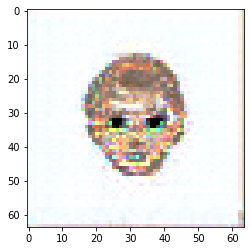

In [ ]:
plt.imshow(predicted_image[0])